In [3]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
test = pd.read_csv("GLC24-PA-metadata-test.csv") #fichier csv qui sera merge pas les prédiction et soumis sur Kaggle
train = pd.read_csv("GLC24-PA-metadata-train.csv" ) #fichier csv presences/absences

In [38]:
k_voisins_proba(60,0.2, train, test)

True

In [37]:
def k_voisins_proba(k,proba, data, test):
    """
    données:
        k: nombre de voisins considérés 
        data: dataFrame contenant entre autre les patch_ID et les espèces associées du train-PA
        test: dataFrame provenant du CSV Kaggle contenant les informations sur les lieux où la prédiction
        doit être faite
    fonction: 
        Liste les espèces présentes dans les k-voisins les plus proches de chaque coordonnées du dataFrame
        test à partir des information de data. 
    résultat:
        resultat: Un fichier CSV contenant les prédicitions d'especes dans la colonne Predicted 
    """
    # data frame contenant les espèces_id selon la lat,lon où l'espèce est recensées (sans doublons)
    data_sans_doublons = data.groupby(['lat', 'lon'])['speciesId'].apply(set).reset_index()

     # Données utilisées par l'algo 
    X1 = test[['lat', 'lon']].values
    X2 = data_sans_doublons[['lat', 'lon']].values

        # Création du modèle
    nn = NearestNeighbors(n_neighbors= k)
    nn.fit(X2)
    # le modèle retourne l'indice des k-voisins ainsi que leurs distances du point
    distances, indices = nn.kneighbors(X1)

    result = []
    for i in range(len(test)):
        nearest_species = {}
        for j in range(len(indices[i])):
            index = indices[i][j]
            species_list = data_sans_doublons.loc[index]['speciesId']
            for species in species_list:
                if species in nearest_species:
                    nearest_species[species] += 1
                else:
                    nearest_species[species] = 1
        selected_species = [species for species, count in nearest_species.items() if count > proba * k]
        result.append(list(selected_species))

    # Traitement pour l'export du CSV au format acceptable par Kaggle
    test['nearest_species'] = result
    test = test[['surveyId', 'nearest_species']]
    test = test.rename(columns={'nearest_species': 'predictions'})    
    test['predictions'] = test['predictions'].apply(lambda x: str(x).replace('[', '').replace(']', '').replace(',', '').replace('.0', ''))
    test.to_csv('60-voisins-proba-02.csv', index=False, sep=',')

    return True 

<AxesSubplot:>

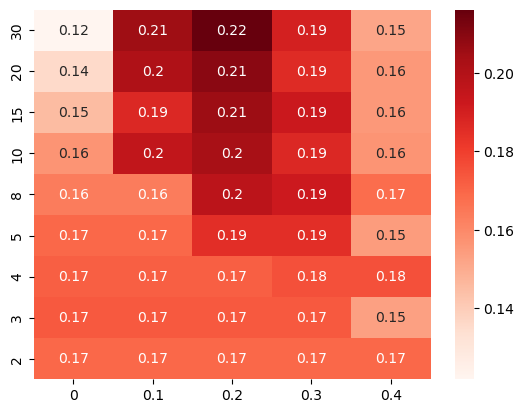

In [10]:
matrice = pd.read_csv('../../Test_Kaggle/k-voisins/matrice.csv', sep = ";")
matrice.head()
matrice = matrice.iloc[::-1]
matrice = matrice.drop('Unnamed: 0', axis=1)
sns.heatmap(matrice, cmap="Reds", annot= True,
            yticklabels=['30', '20','15','10','8','5','4','3','2'])